# Import libraries and set configs

In [1]:
from typing import Union, Tuple 

import sys
sys.path.append("..")

import os
import json
import glob
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = True
    historical = True
    create_dataset = True
    update_dataset = False
    cls_target_ratio_tp = 1.05
    cls_target_ratio_sl = 1.05
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 272
    # for how long time (in hours) we want to predict
    target_offset = 128
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = True
    optimize = False
    # maximum number of simultaneously opened trades
    max_num_simult_trades = 100
    # significance level, that is used to conduct a t-test between 2 models
    optimize_alpha = 0.2 
    n_repeats = 1
    n_folds = 8
    min_precision = 0.5
    last_date = datetime.strptime("2024-09-20:18:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [ ]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]error while signin
you are using nologin method, data you access may be limited
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)



Load the datasets...
MEXCFutures
SAMO_USDT
AURORA_USDT
DAO_USDT
STNK_USDT
FUEL_USDT
PEPE_USDT
TEVA_USDT
AI16Z_USDT
VVAIFU_USDT
MOODENGETH_USDT
EARNM_USDT
SOON_USDT
ARCSOL_USDT
SUPRA_USDT
SWAN_USDT
FLOKI_USDT
ISLAND_USDT
FRED_USDT
CLANKER_USDT
SHIB_USDT
SWFTC_USDT
FILECOIN_USDT
LESTER_USDT
ARCA_USDT
DOGEGOV_USDT
FTT_USDT
VISTA_USDT
ZEREBRO_USDT
ZEX_USDT
TONCOIN_USDT


### Load STOCH_RSI sell data

In [ ]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:83: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)
100%|██████████| 1/1 [26:09<00:00, 1569.17s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9522,0.9183,0.8987,0.8895,0.8797,0.8664,0.8497,0.8329,0.8238,0.8073,0.7961,0.7836,0.7777,0.7747,0.7712,0.7682,0.7641,0.7612,0.7549,0.7499,0.7474,0.746,0.7446,0.7457,0.43,0.85,1.25,1.65,2.03,2.41,2.78,3.14,3.5,3.84,4.17,4.48,4.77,5.01,5.21,5.37,5.49,5.59,5.66,5.7,5.7,5.69,5.67,5.66,45544


# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [ ]:

counter = 0 

tickers_1h = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3126 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

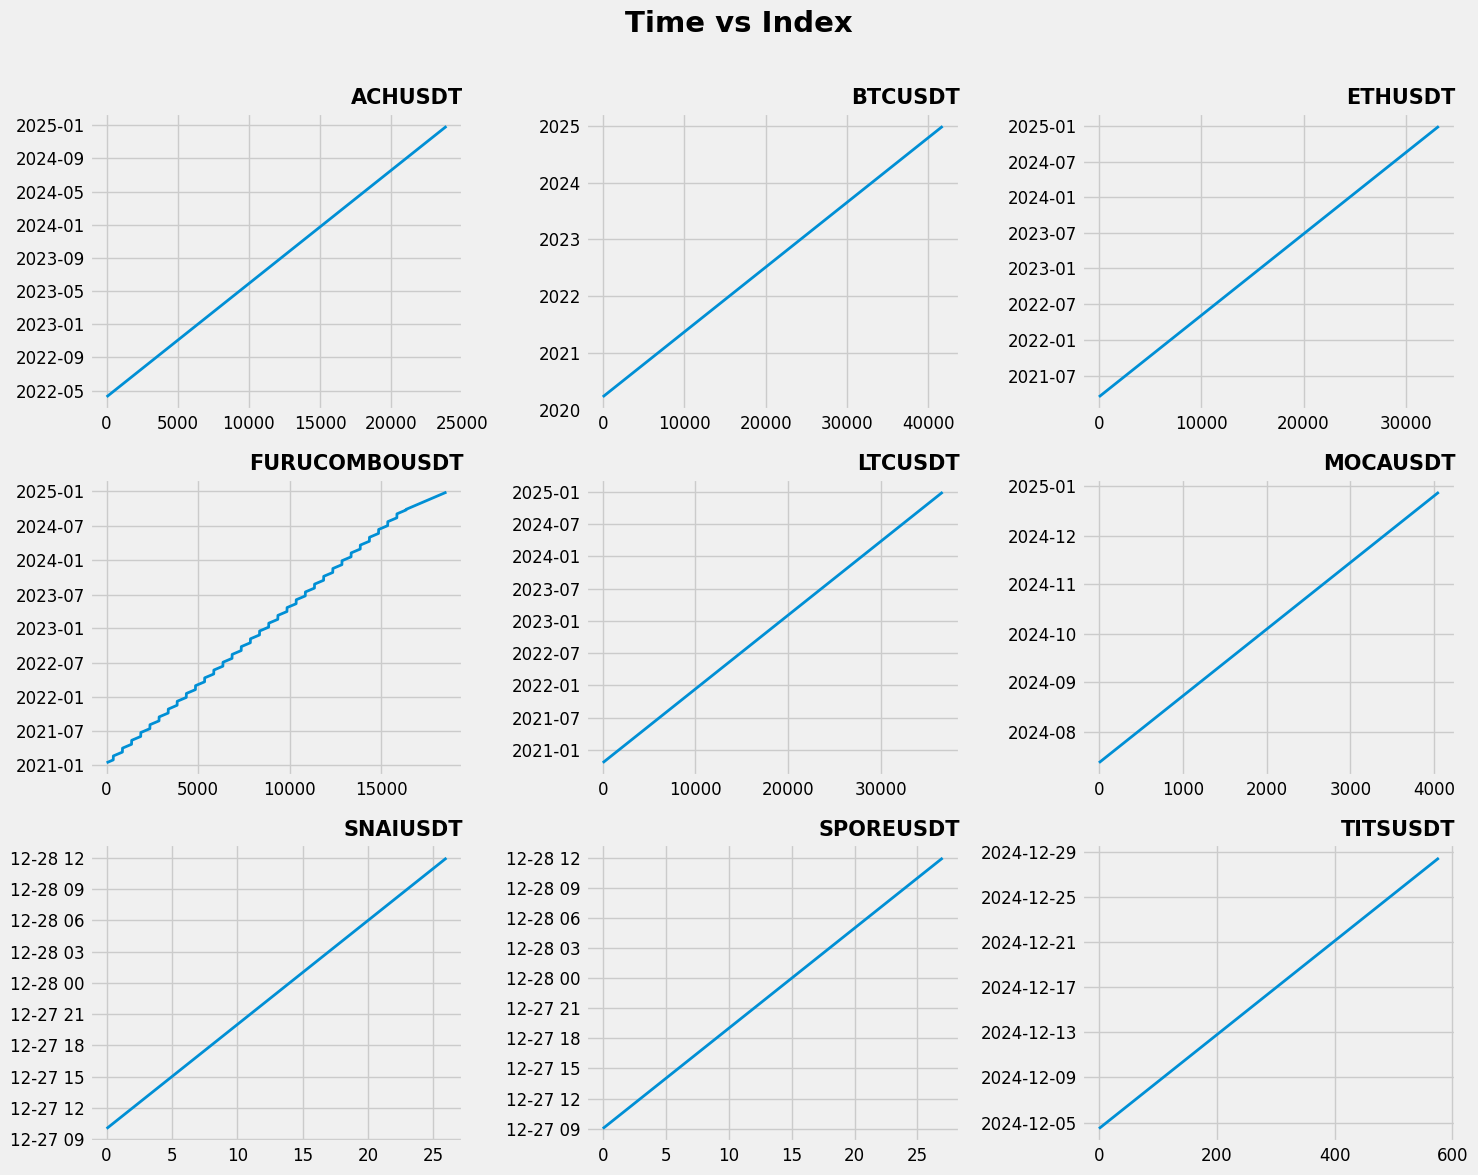

In [ ]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [ ]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = {i[31:].split("USDT")[0] + "USDT" for i in x}
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

EURCUSDC_1h.pklUSDT 1h
EURCUSDC_1h.pklUSDT 4h
EURCUSDC_4h.pklUSDT 1h
EURCUSDC_4h.pklUSDT 4h


# Prepare and create train data

### Functions

In [ ]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["min_price_deviation"] = 0
            row["first_price"] = 0
            row["last_price"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]
            

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue

            row["first_price"] = close_price.values[0]
            row["close_time"] = row["time"].values[0] + pd.to_timedelta(target_offset, unit="h")
            
            close_price = close_price.values[0]
            if ttype == "buy":
                higher_price = close_price * CFG.cls_target_ratio_sl
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            else:
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_sl)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    break
                elif tp1 or tp2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    if row["close_time"].values[0] == row["time"].values[0] + pd.to_timedelta(target_offset, unit="h"):
                        row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    row["target"] = 1
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price
                    # if price doesn't reach both TP and SL - write its last price
                    if row["target"].values[0] == 0:
                        row["last_price"] = last_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price_pos = (target_buy - close_price) / close_price
                    curr_price_neg = (close_price - target_sell) / close_price
                else:
                    curr_price_pos = (close_price - target_sell) / close_price
                    curr_price_neg = (target_buy - close_price) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price_pos) 
                row["min_price_deviation"] = max(row["min_price_deviation"].values[0], curr_price_neg) 
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [ ]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 3, 15, 16, 17, 18, 19, 21, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [2, 5, 8, 9, 11, 14, 17]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, CFG.target_offset, first, CFG.last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, CFG.target_offset, first, CFG.last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

error while signin
you are using nologin method, data you access may be limited


  0%|          | 0/1694 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,cci,sar,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,cci_prev_4,sar_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,cci_prev_8,sar_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,cci_prev_12,sar_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,cci_prev_16,sar_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,cci_prev_20,sar_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,cci_prev_24,sar_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,cci_prev_28,sar_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,cci_prev_32,sar_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,cci_prev_36,sar_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,cci_prev_40,sar_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,...,stoch_slowk_prev_232,stoch_slowd_

(40362, 1566)

  0%|          | 0/1564 [00:00<?, ?it/s]

,time,open,high,low,close,volume,funding_rate,rsi,stoch_slowk,stoch_slowd,stoch_diff,atr,cci,sar,linear_reg,linear_reg_angle,macd,macdhist,macdsignal,btcd_open,btcd_high,btcd_low,btcd_close,btcd_volume,btcdom_open,btcdom_high,btcdom_low,btcdom_close,btcdom_volume,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_diff_prev_4,atr_prev_4,cci_prev_4,sar_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macdsignal_prev_4,btcdom_open_prev_4,btcdom_high_prev_4,btcdom_low_prev_4,btcdom_close_prev_4,btcdom_volume_prev_4,ticker,pattern,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,funding_rate_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_diff_prev_8,atr_prev_8,cci_prev_8,sar_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macdsignal_prev_8,btcdom_open_prev_8,btcdom_high_prev_8,btcdom_low_prev_8,btcdom_close_prev_8,btcdom_volume_prev_8,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_diff_prev_12,atr_prev_12,cci_prev_12,sar_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macdsignal_prev_12,btcdom_open_prev_12,btcdom_high_prev_12,btcdom_low_prev_12,btcdom_close_prev_12,btcdom_volume_prev_12,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,funding_rate_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_diff_prev_16,atr_prev_16,cci_prev_16,sar_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macdsignal_prev_16,btcdom_open_prev_16,btcdom_high_prev_16,btcdom_low_prev_16,btcdom_close_prev_16,btcdom_volume_prev_16,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_diff_prev_20,atr_prev_20,cci_prev_20,sar_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macdsignal_prev_20,btcdom_open_prev_20,btcdom_high_prev_20,btcdom_low_prev_20,btcdom_close_prev_20,btcdom_volume_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,funding_rate_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_diff_prev_24,atr_prev_24,cci_prev_24,sar_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macdsignal_prev_24,btcd_open_prev_24,btcd_high_prev_24,btcd_low_prev_24,btcd_close_prev_24,btcd_volume_prev_24,btcdom_open_prev_24,btcdom_high_prev_24,btcdom_low_prev_24,btcdom_close_prev_24,btcdom_volume_prev_24,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_diff_prev_28,atr_prev_28,cci_prev_28,sar_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macdsignal_prev_28,btcdom_open_prev_28,btcdom_high_prev_28,btcdom_low_prev_28,btcdom_close_prev_28,btcdom_volume_prev_28,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,funding_rate_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_diff_prev_32,atr_prev_32,cci_prev_32,sar_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macdsignal_prev_32,btcdom_open_prev_32,btcdom_high_prev_32,btcdom_low_prev_32,btcdom_close_prev_32,btcdom_volume_prev_32,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_diff_prev_36,atr_prev_36,cci_prev_36,sar_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macdsignal_prev_36,btcdom_open_prev_36,btcdom_high_prev_36,btcdom_low_prev_36,btcdom_close_prev_36,btcdom_volume_prev_36,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,funding_rate_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_diff_prev_40,atr_prev_40,cci_prev_40,sar_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macdsignal_prev_40,btcdom_open_prev_40,btcdom_high_prev_40,btcdom_low_prev_40,...,stoch_slowk_prev_232,stoch_slowd_

(36438, 1566)

NameError: name 'buy_hours_to_save' is not defined

### Create train dataset

In [ ]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

In [ ]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation",
                                                              "min_price_deviation", "ticker", "ttype", "close_time", "first_price", "last_price"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # check if columns that were added for backtest and statistics are correct
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        if row["last_price"] > 0:
            assert row["close_time"] - row["time"] == pd.to_timedelta(CFG.target_offset, unit="h")
            assert round(row["max_price_deviation"], 8) <= CFG.cls_target_ratio_tp - 1
        else:
            assert row["close_time"] - row["time"] <= pd.to_timedelta(CFG.target_offset, unit="h")
            if row["target"] == 1:
                assert round(row["max_price_deviation"], 8) >= CFG.cls_target_ratio_tp - 1
            else:
                assert round(row["max_price_deviation"], 8) < CFG.cls_target_ratio_tp - 1

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")

NameError: name 'buy_hours_to_save' is not defined


### Test buy target corectness

In [ ]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_sl
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

  0%|          | 0/40362 [00:00<?, ?it/s]

### Test sell target corectness

In [ ]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        high_price = close_price * CFG.cls_target_ratio_tp
        low_price = close_price * (2 - CFG.cls_target_ratio_sl)
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/36438 [00:00<?, ?it/s]

### Find minimum acceptable class 1 / class 0 ratio considering singal statistics and our TP / SL ratio

In [ ]:
# if target = 1 but price didn't reach TP - what is percent of cases when it happenes and what is average positive price movement
low_price_dev_num_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1").shape[0]
normal_price_dev_num_1 = train_buy.query("target == 1").shape[0]
avg_low_price_dev_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1")["max_price_deviation"].mean()
low_2_norm_ratio_1 = low_price_dev_num_1/normal_price_dev_num_1

# if target = 0 but price didn't reach SL - what is percent of cases when it happenes and what is average negative price movement
low_price_dev_num_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1").shape[0]
normal_price_dev_num_0 = train_buy.query("target == 0").shape[0]
avg_low_price_dev_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1")["min_price_deviation"].mean()
low_2_norm_ratio_0 = low_price_dev_num_1/normal_price_dev_num_0

for class_1_ratio in np.arange(0.51, 0, -0.001):
    expectation = ((CFG.cls_target_ratio_tp - 1) * (1 - low_2_norm_ratio_1) + avg_low_price_dev_1 * low_2_norm_ratio_1) * class_1_ratio -\
           ((CFG.cls_target_ratio_sl - 1) * (1 - low_2_norm_ratio_0) + avg_low_price_dev_0 * low_2_norm_ratio_0) * (1 - class_1_ratio)
    if expectation < 0:
        print(round(class_1_ratio + 0.001, 4))
        break

0.5


### Test pattern / target distribution

In [ ]:
def q10(x):
    return x.quantile(0.1)

def q20(x):
    return x.quantile(0.2)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.125277,0.055460,0.065786,0.080155,0.301837,810,1423,0.569220,"(0.5436, 0.5948)"
3,1,1,0.129359,0.056873,0.070311,0.086287,0.328080,899,1639,0.548505,"(0.5245, 0.5725)"
5,2,1,0.121079,0.053602,0.063360,0.076558,0.293715,926,1828,0.506565,"(0.4838, 0.5294)"
7,3,1,0.121414,0.056987,0.068798,0.083633,0.281546,1091,1961,0.556349,"(0.5345, 0.5782)"
9,4,1,0.112182,0.056236,0.067577,0.080641,0.293549,949,1862,0.509667,"(0.4871, 0.5323)"
11,5,1,0.115615,0.056517,0.068203,0.077766,0.302416,786,1584,0.496212,"(0.4717, 0.5207)"
13,6,1,0.117186,0.055189,0.064127,0.077802,0.307371,740,1498,0.493992,"(0.4688, 0.5192)"
15,7,1,0.106611,0.054573,0.064351,0.074688,0.279804,676,1332,0.507508,"(0.4808, 0.5342)"
17,8,1,0.112954,0.055662,0.063755,0.074513,0.306409,625,1362,0.458884,"(0.4326, 0.4852)"
19,9,1,0.119647,0.054324,0.064683,0.078590,0.344078,630,1359,0.463576,"(0.4372, 0.49)"


buy    40362
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    21362
0       STOCH_RSI_Volume24    19000
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.52926
0       STOCH_RSI_Volume24    0.47074
dtype: float64

[0, 1, 3, 15, 16, 17, 18, 19, 21, 22, 23]

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.117647,0.058820,0.066572,0.080312,0.390069,409,829,0.493366,"(0.4595, 0.5272)"
3,1,1,0.117227,0.053836,0.063634,0.079427,0.391140,490,997,0.491474,"(0.4606, 0.5223)"
5,2,1,0.104093,0.053976,0.063511,0.074509,0.291682,726,1382,0.525326,"(0.4991, 0.5515)"
7,3,1,0.109881,0.057123,0.068360,0.081998,0.341087,829,1670,0.496407,"(0.4725, 0.5203)"
9,4,1,0.111833,0.054476,0.065074,0.078836,0.343005,832,1640,0.507317,"(0.4832, 0.5314)"
11,5,1,0.117756,0.058543,0.068359,0.081853,0.359350,915,1743,0.524957,"(0.5016, 0.5483)"
13,6,1,0.112945,0.057615,0.068573,0.081217,0.316441,811,1617,0.501546,"(0.4773, 0.5258)"
15,7,1,0.126455,0.056442,0.068745,0.083917,0.327458,797,1649,0.483323,"(0.4593, 0.5073)"
17,8,1,0.114860,0.056491,0.066599,0.080670,0.320550,803,1506,0.533201,"(0.5081, 0.5583)"
19,9,1,0.123059,0.059888,0.071386,0.085993,0.316795,757,1361,0.556209,"(0.5299, 0.5825)"


sell    36438
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    18740
0       STOCH_RSI_Volume24    17698
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.514298
0       STOCH_RSI_Volume24    0.485702
dtype: float64

[2, 5, 8, 9, 11, 14, 17]

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

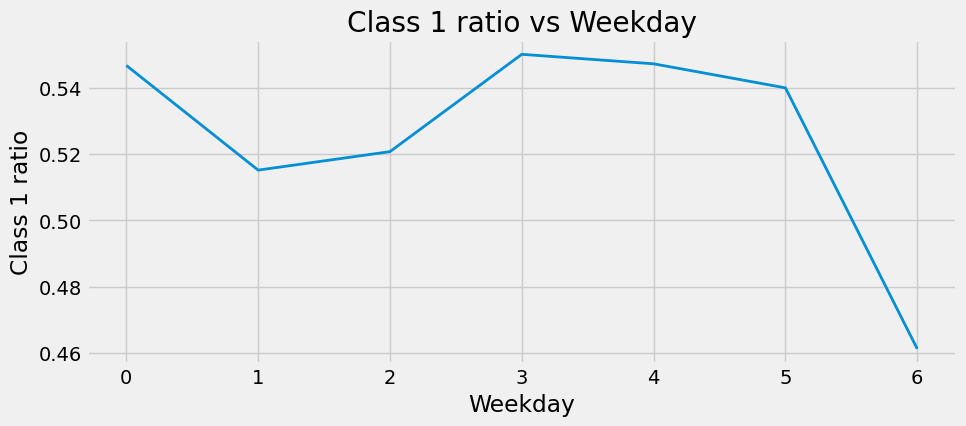

In [ ]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

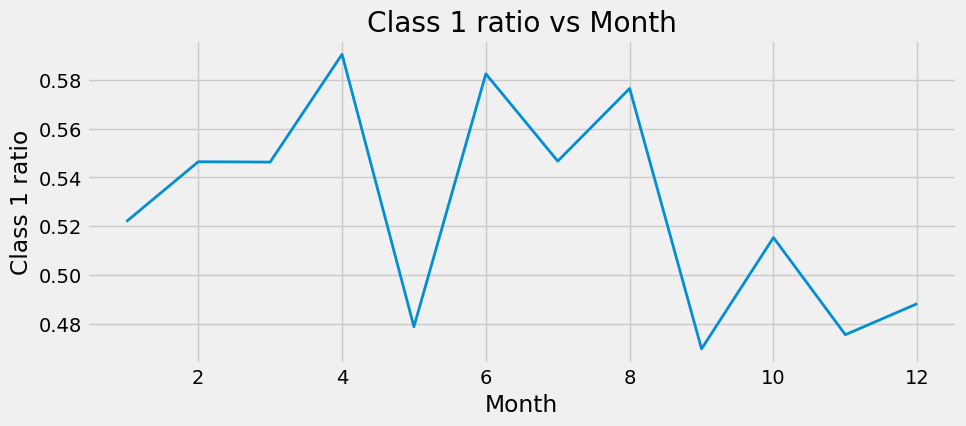

In [ ]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

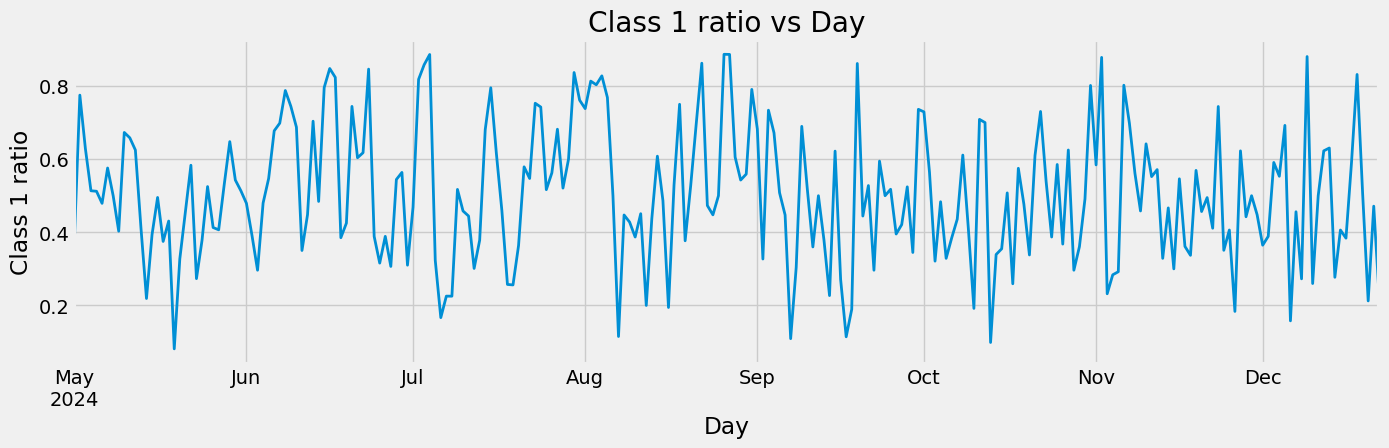

In [ ]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_sl
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [ ]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_sl)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

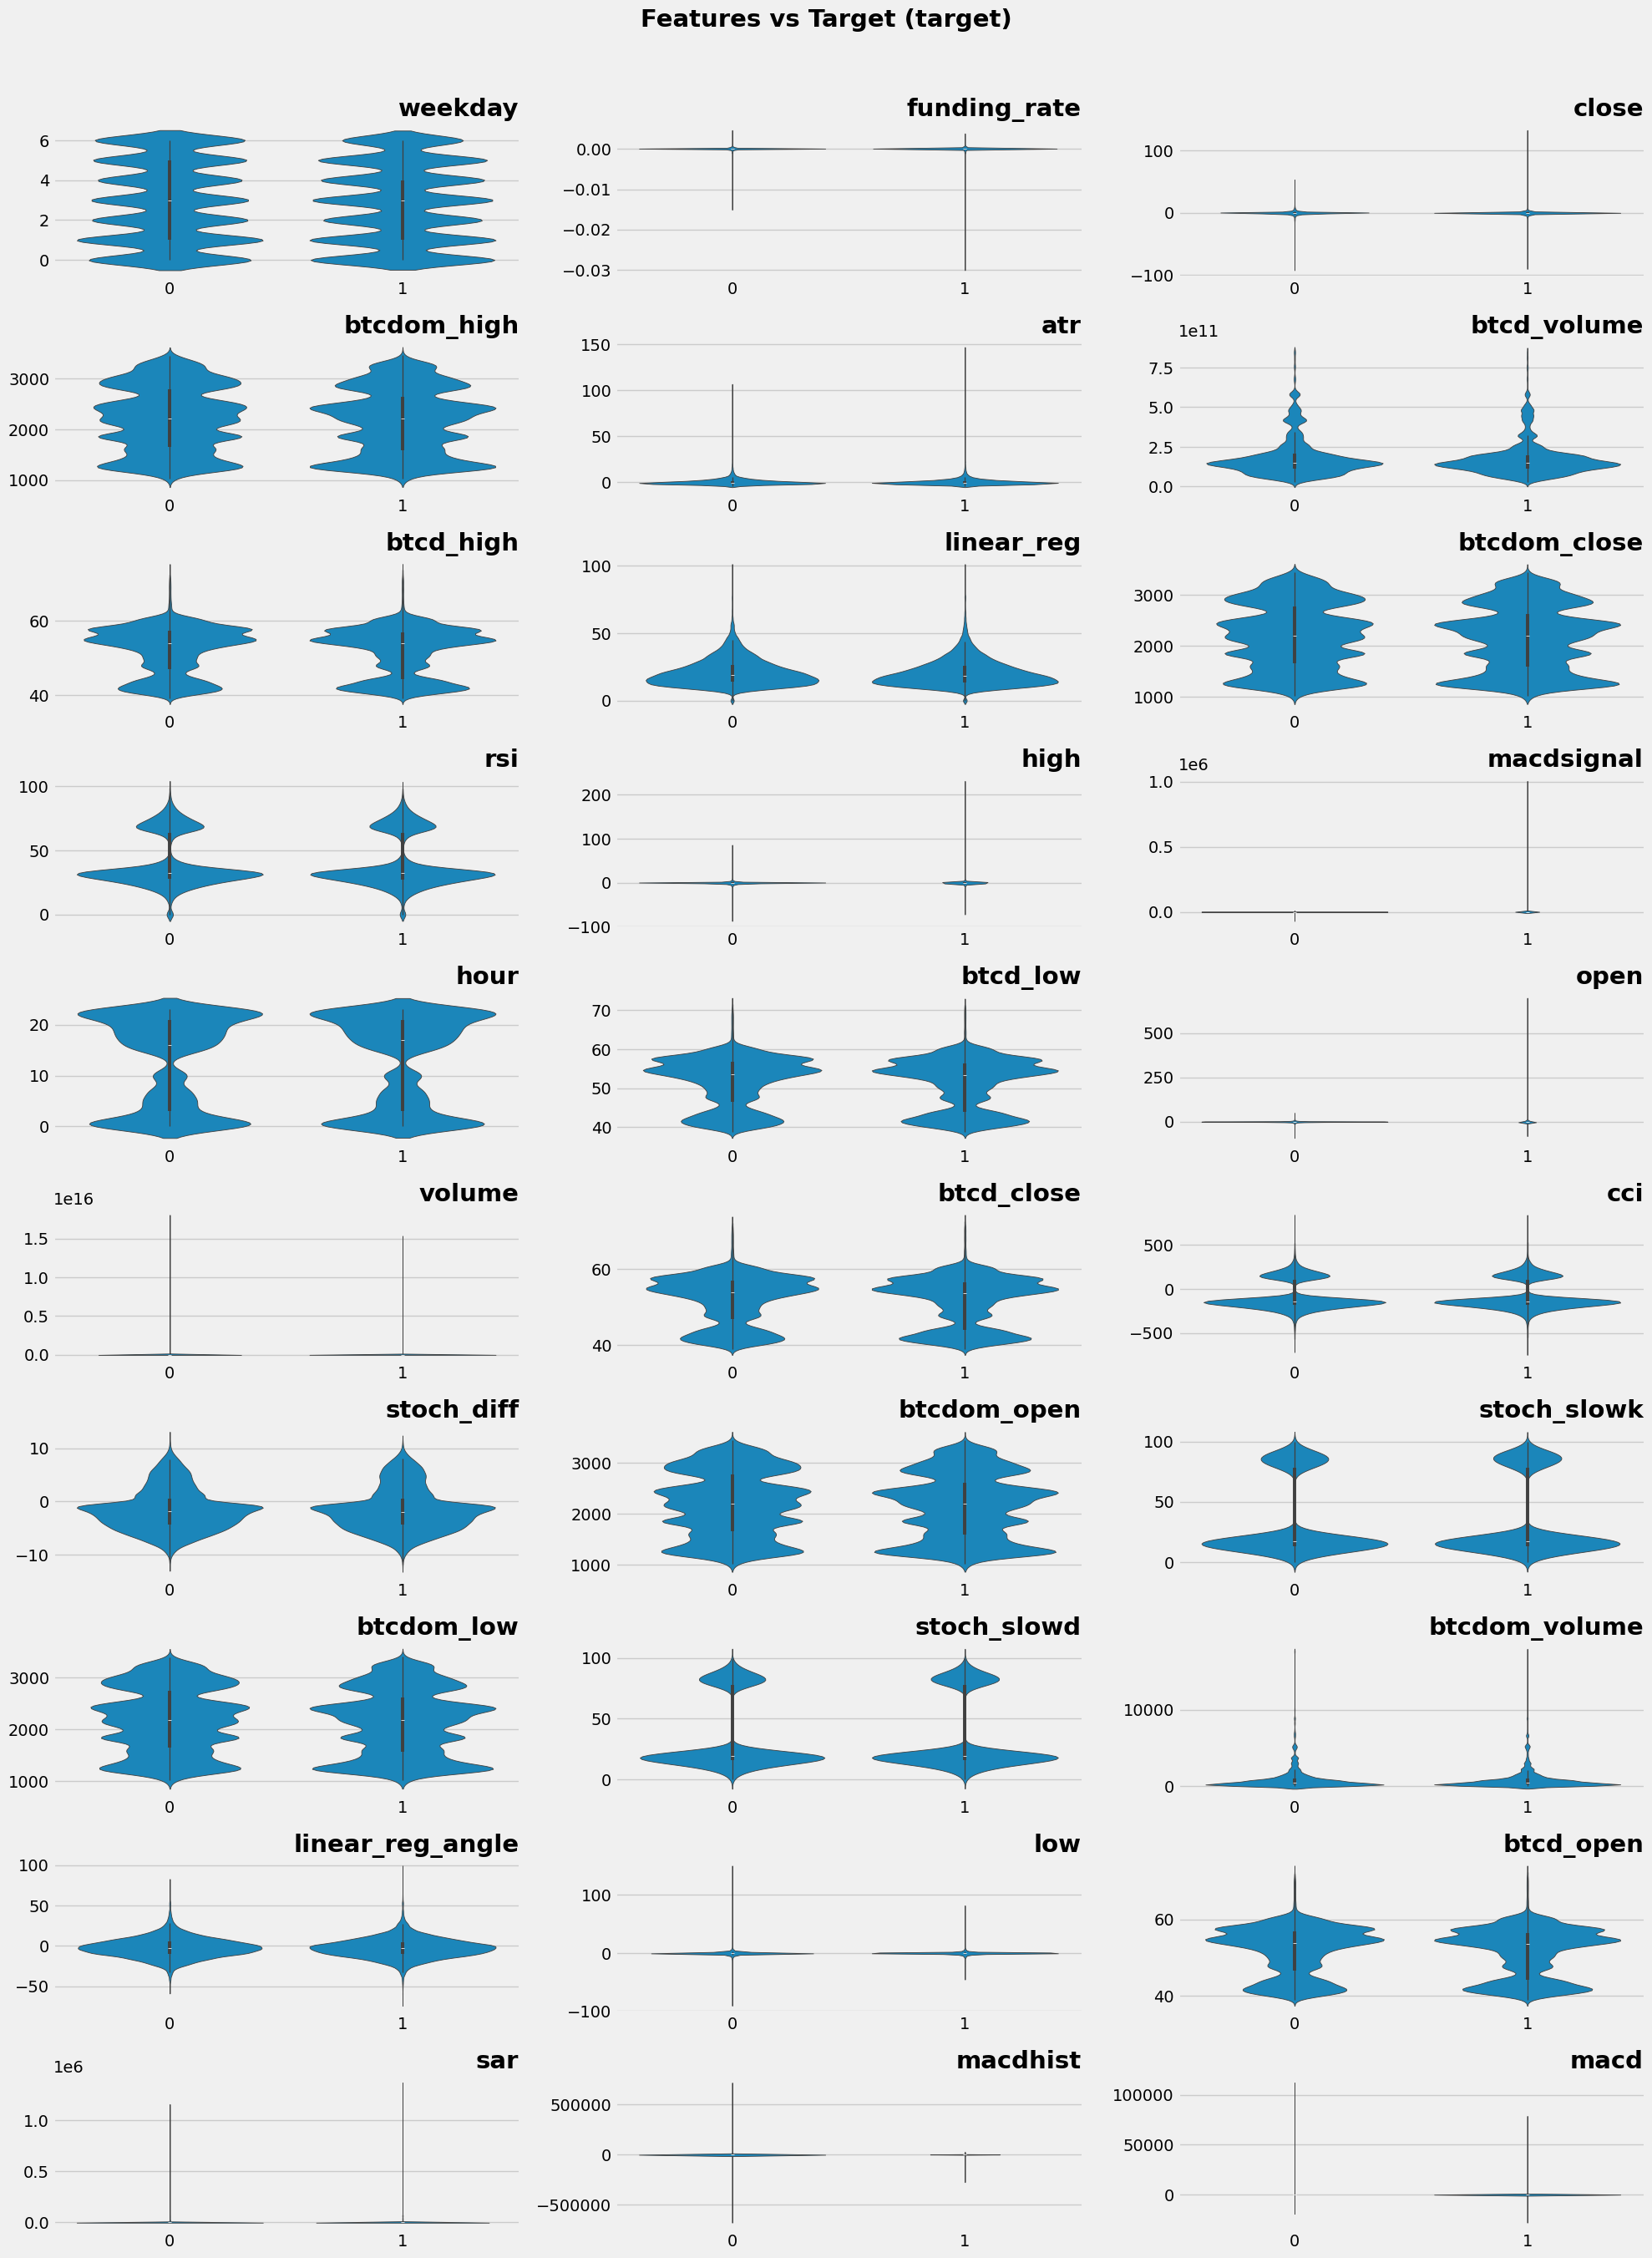

In [ ]:
train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday

fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [ ]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50)

,time,ticker,ttype,pattern
182937,2024-12-22 07:00:00,MAFUSDT,buy,STOCH_RSI_Volume24
182938,2024-12-22 07:00:00,LKYUSDT,buy,STOCH_RSI_Volume24
182939,2024-12-22 07:00:00,1000TOSHIUSDT,buy,STOCH_RSI_Volume24
182940,2024-12-22 07:00:00,AEROUSDT,buy,STOCH_RSI_Volume24
182941,2024-12-22 07:00:00,VRUSDT,buy,STOCH_RSI_Volume24
182942,2024-12-22 07:00:00,MOEWUSDT,buy,STOCH_RSI_Volume24
182943,2024-12-22 07:00:00,PENGUUSDT,buy,STOCH_RSI_Volume24
182944,2024-12-22 08:00:00,CHEXUSDT,buy,STOCH_RSI_Volume24
182945,2024-12-22 08:00:00,SENDUSDT,buy,STOCH_RSI_Volume24
182946,2024-12-22 08:00:00,HIVE_USDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [ ]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "gbdt",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 6,
          "subsample" : 0.7,
          "colsample_bytree": 0.7,
          "verbosity": -1,
          "importance_type": "gain",
          "objective": "binary",
          "metric": "average_precison",
          "verbose": -1
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "weight",
                                                     "max_price_deviation", "min_price_deviation", "close_time", "first_price", "last_price"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df, n_folds=4):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(X) * 2) // (n_folds * 3))

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000, perc=99)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError as re:
            print(re)
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [ ]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, n_folds=4, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(X) * 2) // (n_folds * 3))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=4, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [ ]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([
        perm_df_[["Feature","rank"]], 
        feature_importances_[["Feature","rank"]], 
        rfe_df_[["Feature","rank"]],
        boruta_df_[["Feature","rank"]],
                    ])
    fi = fi.groupby("Feature")["rank"].sum().reset_index()
    # these features are very important they must be among features anyway
    for feature in ["weekday", "funding_rate", "macdhist_prev_4"]:
        fi.loc[fi["Feature"] == feature, "rank"] = fi.loc[fi["Feature"] == feature, "rank"].values[0] / 100
    fi = fi.sort_values("rank").reset_index(drop=True)
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load best parameters from Optuna dataframe

In [ ]:
def load_params_from_optuna(row_num=0) -> dict:
    try:
        optuna_df = pd.read_csv("optuna/optuna_lgbm.csv")
    except FileNotFoundError:
        return {}
    columns = [c for c in optuna_df.columns if c.startswith("params_")]
    row = optuna_df[columns].iloc[row_num]
    params = {key[7:]: value for key, value in row.to_dict().items()}
    if params["sample_weight"] != params["sample_weight"]:
        params["sample_weight"]  = None
    if params["is_unbalance"] is True:
        if "class_weight" not in params or params["class_weight"] != params["class_weight"]:
            params["class_weight"] = None
        else:
            params["class_weight"] = "balanced"
    return params

params = load_params_from_optuna(row_num=0)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7703790953152492,
 'corr_thresh': 0.8895919933709201,
 'feature_num': 278,
 'high_bound': 0.4333085023167236,
 'is_unbalance': True,
 'learning_rate': 0.0078750219061301,
 'low_bound': 0.0167271483880021,
 'max_bin': 159,
 'max_depth': 6,
 'max_train_size': 0.8542049401812354,
 'n_estimators': 628,
 'num_leaves': 128,
 'reg_alpha': 0.1284227104261404,
 'reg_lambda': 0.0001508879580246,
 'sample_weight': 'cos',
 'subsample': 0.8669375874836542,
 'class_weight': None}

### Functions for train

In [ ]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            else:
                sample_weight = None
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score - 1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on the latest data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Load selected features

In [ ]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

if CFG.optimize:
    feature_num = 100
    corr_thresh = 0.7

if "feature_num" in params:
    if not CFG.optimize:
        feature_num = params["feature_num"]
        corr_thresh = params["corr_thresh"]

    del params["feature_num"]
    del params["corr_thresh"]

fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)

assert len(features) == len(set(features))

display(features, len(features))

['weekday',
 'funding_rate',
 'close',
 'atr',
 'btcd_volume',
 'linear_reg',
 'rsi',
 'high',
 'macdhist_prev_4',
 'stoch_slowd_prev_4',
 'low_prev_4',
 'cci_prev_4',
 'high_prev_8',
 'stoch_diff_prev_8',
 'stoch_slowd_prev_8',
 'atr_prev_12',
 'btcdom_volume_prev_12',
 'stoch_slowk_prev_12',
 'rsi_prev_12',
 'cci_prev_12',
 'btcdom_volume_prev_16',
 'stoch_slowd_prev_16',
 'btcdom_volume_prev_20',
 'low_prev_20',
 'stoch_slowk_prev_20',
 'open_prev_24',
 'atr_prev_24',
 'btcd_volume_prev_24',
 'rsi_prev_28',
 'stoch_slowk_prev_28',
 'btcdom_volume_prev_32',
 'stoch_slowk_prev_32',
 'atr_prev_32',
 'cci_prev_32',
 'btcdom_volume_prev_36',
 'high_prev_36',
 'stoch_slowd_prev_36',
 'atr_prev_36',
 'stoch_diff_prev_40',
 'cci_prev_40',
 'stoch_slowd_prev_40',
 'rsi_prev_44',
 'close_prev_44',
 'stoch_slowd_prev_44',
 'btcdom_volume_prev_44',
 'cci_prev_48',
 'low_prev_48',
 'open_prev_48',
 'close_prev_48',
 'btcd_volume_prev_48',
 'atr_prev_48',
 'btcdom_volume_prev_48',
 'atr_prev_52',

225

### Additional feature selection: add features that significantly increase fold score

In [ ]:
def add_feature_selection(features):

    features_to_select = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "weight",
                                                                    "max_price_deviation", "min_price_deviation", "close_time", "first_price", "last_price"] and c not in features]
    features_to_add = []

    params = {
            "boosting_type": "gbdt",
            "n_estimators": 1000,
            "learning_rate": 0.02,
            "max_depth": 6,
            "subsample" : 0.7,
            "colsample_bytree": 0.7,
            "verbosity": -1,
            "importance_type": "gain",
            "objective": "binary",
            "metric": "average_precison",
            "verbose": -1
            }

    _, best_scores, _, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], 
                                            features, params, None, 
                                            n_folds=5, low_bound=0, 
                                            high_bound=0.5, train_test="fold", 
                                            max_train_size=None, verbose=False)

    for feature in tqdm(features_to_select):
        _, scores, _, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], 
                                            features + [feature], params, None, 
                                            n_folds=5, low_bound=0, 
                                            high_bound=0.5, train_test="fold", 
                                            max_train_size=None, verbose=False)
        p_value = ttest_rel(scores, best_scores, alternative="greater").pvalue
        if p_value <= 0.1:
            features_to_add.append(feature)
            print(feature)

# if CFG.select_features:
#     features_to_add = add_feature_selection(features)

### Functions for backtest

In [ ]:
risk = 0.0026 # what part of deposit we use in one trade
leverage = 4
price_change = CFG.cls_target_ratio_sl * leverage
min_free_balance = 0.2

open_comission = 0.00036 # Bybit comission for trade opening
close_comission = 0.001 # Bybit comission for trade closing

# consider trade slippage, let it be ~ 0.2%
slippage = 0.002
TP = CFG.cls_target_ratio_tp - slippage
SL = CFG.cls_target_ratio_sl + slippage

def calculate_profit(target, quantity, first_price, last_price):
    """Calculate profit change according to trade success and comissions"""
    if target == 1:
        if last_price > 0: 
            # if price doesn't reach TP or SL - calculate profit
            # from price of entering and exiting of trade
            trade_profit = quantity * (1 + (last_price - first_price) / first_price * leverage)
        else:
            # TP reached
            trade_profit = quantity * (1 + TP * leverage)
    else:
        # SL reached
        trade_profit = quantity * (1 - SL * leverage)
        
    # subtract Bybit close comission 
    trade_profit *=  (1 - close_comission)
    # subtract possible slippage

    profit = trade_profit - quantity
    return profit, trade_profit


def cap_max_num_simult_trades(df, max_num_simult_trades):
    """ Cap the maximum number of simulatenously opened trades """
    df["row_number"] = df.sort_values("pred", ascending=False).groupby("time")["target"].cumcount() + 1
    df = df[df["row_number"] <= max_num_simult_trades]
    return df


def backtest(df: pd.DataFrame, oof: pd.Series, val_idxs: pd.Series, high_bound: float, 
             show_progress: bool = False, max_num_simult_trades: int = 0) -> float:
    # 
    """Function for model backtest"""
    # select only trades in which model is confident
    backtest_df = df.loc[val_idxs, ["target", "max_price_deviation", "time", "close_time", "first_price", "last_price"]]
    backtest_df["pred"] = oof
    backtest_df = backtest_df[backtest_df["pred"] >= high_bound]
    if max_num_simult_trades > 0:
        backtest_df = cap_max_num_simult_trades(backtest_df, max_num_simult_trades)
    backtest_df = backtest_df.reset_index(drop=True)
    backtest_df["balance"] = 1
    backtest_df["free_balance"] = 1
    backtest_df["profit"] = 0
    backtest_df["trade_profit"] = 0
    backtest_df["quantity"] = 0
    backtest_df["profit_count"] = 0

    # set for tracking of not closed trades
    not_closed_trade_idxs = set()
    
    if show_progress:
        generator = tqdm(backtest_df.iterrows(), total=len(backtest_df))
    else:
        generator = backtest_df.iterrows()

    # move through the dataset row-by-row
    for i, row in generator:
        j = i - 1
        # take balance from previous signal 
        # or if signal is first - set balance to 1
        if j >= 0:
            balance = backtest_df.loc[j, "balance"]
            free_balance = backtest_df.loc[j, "free_balance"]
        else:
            balance = free_balance = 1
        
        signal_time = row["time"]
        target = row["target"]
        first_price = row["first_price"]
        last_price = row["last_price"]
        
        closed_trade_idxs = []
        
        # update balance with previous signals info
        for j in not_closed_trade_idxs:
            prev_signal_close_time = backtest_df.loc[j, "close_time"]
            # if previous signal was closed - add its profit to the current balance 
            if signal_time >= prev_signal_close_time:
                free_balance += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "trade_profit"] += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "profit_count"] += 1
                closed_trade_idxs.append(j)

        # remove closed trades from set of not closed trades
        for j in closed_trade_idxs:
            not_closed_trade_idxs.remove(j)

        # perform trading operation only if have enough of free balance
        if free_balance >= min_free_balance * balance:
            # calculate quantity to use in trade
            quantity = free_balance * risk / price_change
            # subtact quantity + open comission from balance
            balance -= quantity * open_comission
            free_balance -= (quantity * (1 + open_comission))
            # get profit from the current trade
            profit, trade_profit = calculate_profit(target, quantity, first_price, last_price)
        else:
            profit, trade_profit = 0, 0

        # write balance and profit to the dataset
        backtest_df.loc[i, "quantity"] = quantity
        backtest_df.loc[i, "balance"] = balance + profit
        backtest_df.loc[i, "free_balance"] = free_balance
        backtest_df.loc[i, "profit"] = profit
        backtest_df.loc[i, "trade_profit"] = trade_profit

        not_closed_trade_idxs.add(i)

    if len(backtest_df) > 0:
        result = round(backtest_df['balance'].iloc[-1] * 100, 2) - 100
    else:
        result = 0
    return result, backtest_df

### Functions for optimization

In [ ]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.3, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 
    else:
        params["class_weight"] = None

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    # train model, get results
    _, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=CFG.n_folds, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    backtest_result, _ = backtest(train_df, oof, val_idxs, high_bound)
    result = backtest_result * oof_conf_score
    
    # prepare result list for t-test
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("result == result.max()")[["result", "scores"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(scores, best_scores, alternative="greater").pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                # increase result but discount the difference betweeen current result
                # and previous best result on (1 - p_value) 
                result = best_result + np.abs(result - best_result) * (1 - p_value)
    
    tmp = pd.DataFrame({
                        "result": [result], 
                        "backtest_result": [backtest_result],
                        "oof_conf_score": [oof_conf_score],
                        "profit_objects": [profit_objects],
                        "oof_conf_obj_num": [oof_conf_obj_num],
                        "scores": [(scores)], 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

Training with 225 features
Fold #1


1    0.500168
0    0.499832
Name: target, dtype: float64

Timestamp('2023-03-08 16:00:00')

Timestamp('2023-06-28 10:00:00')

[100]	training's binary_logloss: 0.610401	valid_1's binary_logloss: 0.689901
[200]	training's binary_logloss: 0.571612	valid_1's binary_logloss: 0.690306
[300]	training's binary_logloss: 0.54625	valid_1's binary_logloss: 0.692151
[400]	training's binary_logloss: 0.525409	valid_1's binary_logloss: 0.693418
[500]	training's binary_logloss: 0.506109	valid_1's binary_logloss: 0.693593
[600]	training's binary_logloss: 0.489061	valid_1's binary_logloss: 0.693575
Logloss: 0.6942703919390579, Confident objects score: 0.5305703734099303
Number of confident objects 2437, % of confident objects: 0.8202625378660384
Number of profitable objects: 149
Fold #2


0    0.545546
1    0.454454
Name: target, dtype: float64

Timestamp('2023-07-03 00:00:00')

Timestamp('2023-11-08 22:00:00')

[100]	training's binary_logloss: 0.614174	valid_1's binary_logloss: 0.689761
[200]	training's binary_logloss: 0.57834	valid_1's binary_logloss: 0.68501
[300]	training's binary_logloss: 0.554492	valid_1's binary_logloss: 0.6832
[400]	training's binary_logloss: 0.534513	valid_1's binary_logloss: 0.682615
[500]	training's binary_logloss: 0.517604	valid_1's binary_logloss: 0.683393
[600]	training's binary_logloss: 0.502288	valid_1's binary_logloss: 0.684897
Logloss: 0.6848915489527938, Confident objects score: 0.481044650379107
Number of confident objects 2374, % of confident objects: 0.7921254587921255
Number of profitable objects: -90
Fold #3


0    0.524094
1    0.475906
Name: target, dtype: float64

Timestamp('2023-11-12 23:00:00')

Timestamp('2024-02-01 07:00:00')

[100]	training's binary_logloss: 0.627153	valid_1's binary_logloss: 0.692179
[200]	training's binary_logloss: 0.593699	valid_1's binary_logloss: 0.692522
[300]	training's binary_logloss: 0.57213	valid_1's binary_logloss: 0.694518
[400]	training's binary_logloss: 0.554409	valid_1's binary_logloss: 0.695851
[500]	training's binary_logloss: 0.53798	valid_1's binary_logloss: 0.697285
[600]	training's binary_logloss: 0.522787	valid_1's binary_logloss: 0.698207
Logloss: 0.69836516497724, Confident objects score: 0.4952170713760118
Number of confident objects 1359, % of confident objects: 0.5076578259245424
Number of profitable objects: -13
Fold #4


1    0.622435
0    0.377565
Name: target, dtype: float64

Timestamp('2024-02-05 21:00:00')

Timestamp('2024-04-07 05:00:00')

[100]	training's binary_logloss: 0.633137	valid_1's binary_logloss: 0.692308
[200]	training's binary_logloss: 0.601337	valid_1's binary_logloss: 0.69831
[300]	training's binary_logloss: 0.58322	valid_1's binary_logloss: 0.701929
[400]	training's binary_logloss: 0.567929	valid_1's binary_logloss: 0.702272
[500]	training's binary_logloss: 0.55448	valid_1's binary_logloss: 0.70175
[600]	training's binary_logloss: 0.542011	valid_1's binary_logloss: 0.702375
Logloss: 0.702053362434308, Confident objects score: 0.660411622276029
Number of confident objects 1652, % of confident objects: 0.7533059735522116
Number of profitable objects: 530
Fold #5


1    0.532506
0    0.467494
Name: target, dtype: float64

Timestamp('2024-04-11 10:00:00')

Timestamp('2024-05-19 21:00:00')

[100]	training's binary_logloss: 0.635211	valid_1's binary_logloss: 0.661147
[200]	training's binary_logloss: 0.607653	valid_1's binary_logloss: 0.651899
[300]	training's binary_logloss: 0.589967	valid_1's binary_logloss: 0.650523
[400]	training's binary_logloss: 0.575001	valid_1's binary_logloss: 0.650582
[500]	training's binary_logloss: 0.561019	valid_1's binary_logloss: 0.650014
[600]	training's binary_logloss: 0.548062	valid_1's binary_logloss: 0.649879
Logloss: 0.6499328398609494, Confident objects score: 0.6291512915129152
Number of confident objects 1626, % of confident objects: 0.6954662104362703
Number of profitable objects: 420
Fold #6


1    0.608089
0    0.391911
Name: target, dtype: float64

Timestamp('2024-05-23 22:00:00')

Timestamp('2024-07-04 16:00:00')

[100]	training's binary_logloss: 0.636723	valid_1's binary_logloss: 0.699815
[200]	training's binary_logloss: 0.607943	valid_1's binary_logloss: 0.713305
[300]	training's binary_logloss: 0.591347	valid_1's binary_logloss: 0.720876
[400]	training's binary_logloss: 0.57684	valid_1's binary_logloss: 0.723524
[500]	training's binary_logloss: 0.564136	valid_1's binary_logloss: 0.726637
[600]	training's binary_logloss: 0.552202	valid_1's binary_logloss: 0.729327
Logloss: 0.7290045855145555, Confident objects score: 0.6520376175548589
Number of confident objects 1276, % of confident objects: 0.614347616754935
Number of profitable objects: 388
Fold #7


1    0.589425
0    0.410575
Name: target, dtype: float64

Timestamp('2024-07-08 23:00:00')

Timestamp('2024-08-14 23:00:00')

[100]	training's binary_logloss: 0.644702	valid_1's binary_logloss: 0.682922
[200]	training's binary_logloss: 0.619405	valid_1's binary_logloss: 0.692249
[300]	training's binary_logloss: 0.602454	valid_1's binary_logloss: 0.701228
[400]	training's binary_logloss: 0.587875	valid_1's binary_logloss: 0.704937
[500]	training's binary_logloss: 0.575515	valid_1's binary_logloss: 0.709181
[600]	training's binary_logloss: 0.563676	valid_1's binary_logloss: 0.712122
Logloss: 0.7122856686037633, Confident objects score: 0.667447306791569
Number of confident objects 1281, % of confident objects: 0.5889655172413794
Number of profitable objects: 429
Fold #8


1    0.56735
0    0.43265
Name: target, dtype: float64

Timestamp('2024-08-19 00:00:00')

Timestamp('2024-09-20 17:00:00')

[100]	training's binary_logloss: 0.637266	valid_1's binary_logloss: 0.706913
[200]	training's binary_logloss: 0.607679	valid_1's binary_logloss: 0.729803
[300]	training's binary_logloss: 0.590861	valid_1's binary_logloss: 0.739514
[400]	training's binary_logloss: 0.577417	valid_1's binary_logloss: 0.743128
[500]	training's binary_logloss: 0.565403	valid_1's binary_logloss: 0.746639
[600]	training's binary_logloss: 0.554338	valid_1's binary_logloss: 0.748622
Logloss: 0.7496994590775516, Confident objects score: 0.5248259860788863
Number of confident objects 2155, % of confident objects: 0.7887994143484627
Number of profitable objects: 107


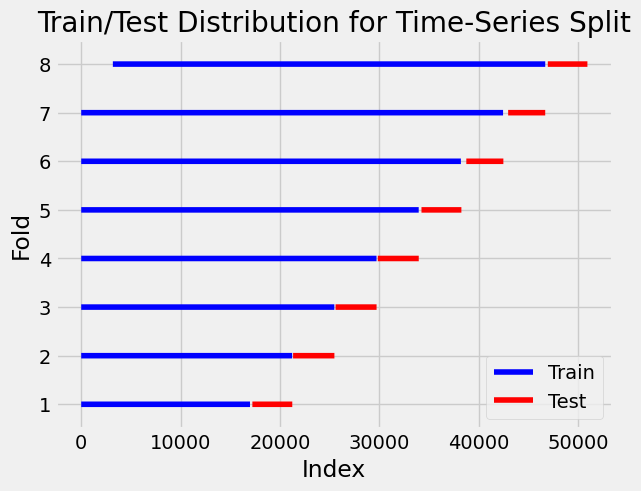

Total confident object score: 0.5677966101694916
Total number of confident objects 14160
Total number of profitable objects: 1920
Scores: [7450.000000000013, -4500.000000000002, -649.9999999999983, 26499.999999999993, 21000.000000000007, 19399.999999999993, 21449.999999999993, 5349.999999999999]


In [ ]:
train_test = "fold"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
if "max_train_size" in params:
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

# set high and low bound for model predictions
# p > high_bound -> 1, p < low_bound -> 0
if "high_bound" in params:
    high_bound = params["high_bound"]
    del params["high_bound"]
    del params["low_bound"]
low_bound = 0

# add object weights
if "sample_weight" in params:
    sample_weight = params["sample_weight"]
    del params["sample_weight"]

if sample_weight == "cos":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
    train_df["weight"] = np.cos(train_df["weight"])
    sample_weight = True
elif sample_weight == "linear":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min())
    sample_weight = True


params["objective"] = "binary"
params["verbosity"] = -1
if params["boosting_type"] != "goss":
    params["subsample_freq"] = 1
else:
    params["subsample"] = None
    params["subsample_freq"] = None
params["importance_type"] = "gain"
params["metric"] = "average_precison"

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["result", "backtest_result", "oof_conf_score", 
                                                "profit_objects", "oof_conf_obj_num", "scores"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv", index=False)

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight, 
                                                                      n_folds=CFG.n_folds, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score - 1) * oof_conf_obj_num)}")
    
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Scores: {scores}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

### Test result of the new model against the result of the old model

In [ ]:
# # TSS fold scores with sample weight
# a =  [385.00000000000085, -3110.0000000000036, -8865.0, -979.9999999999998, 7229.999999999995, -17095.0, 23465.000000000007, 16540.000000000007]
# # TSS fold scores with threshold 0.5
# b =  [1955.0, 54.999999999998074, -315.0, -210.0, 2364.9999999999995, 6645.0, 10680.0, -3554.9999999999995]

# ttest_rel(b, a, alternative="greater")

### Visualize train results

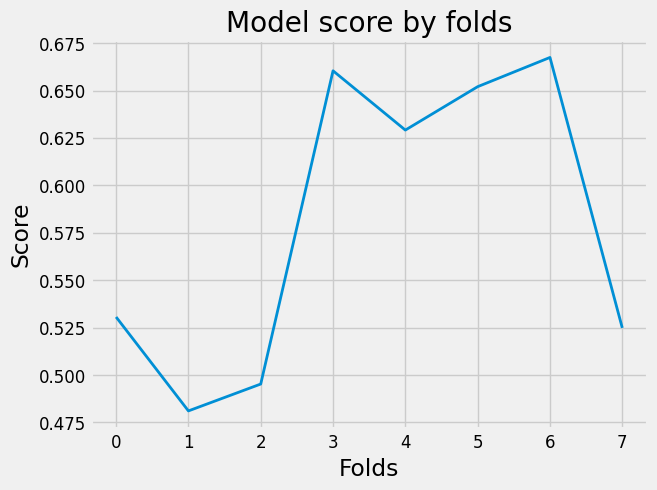

In [ ]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores, linewidth=2)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Backtest model

I don't consider funding fees because the can be both positive and negative. I can do it because typical funding fee is positive and majority of my trade are shorts, so I can even earn on funding. But I think it's better not to consider it at all.


  0%|          | 0/14138 [00:00<?, ?it/s]

Result balance increase is 944.78%


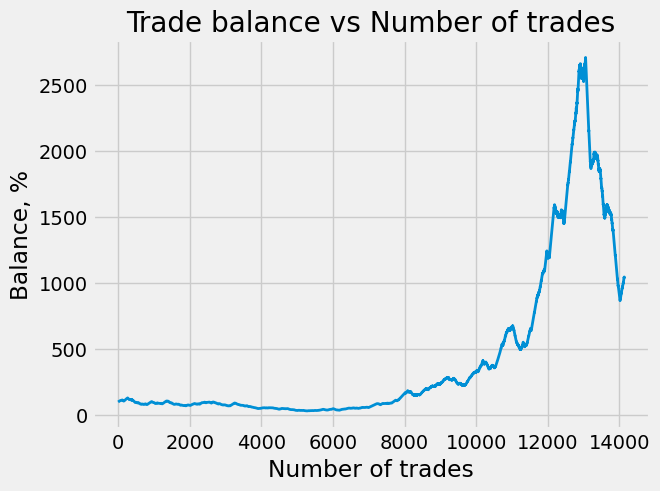

In [ ]:
if not CFG.optimize and train_test == "fold":
    result, backtest_df = backtest(train_df, oof, val_idxs, high_bound, show_progress=True, 
                                max_num_simult_trades=CFG.max_num_simult_trades)
        
    # plot the balance
    backtest_plot = backtest_df["balance"].reset_index(drop=True)
    backtest_plot = backtest_plot * 100

    print(f"Result balance increase is {round(result, 3)}%")

    plt.xlabel('Number of trades')
    plt.ylabel('Balance, %')
    plt.title('Trade balance vs Number of trades')
    backtest_plot.plot(linewidth=2);

### Display PR curve for fold predictions

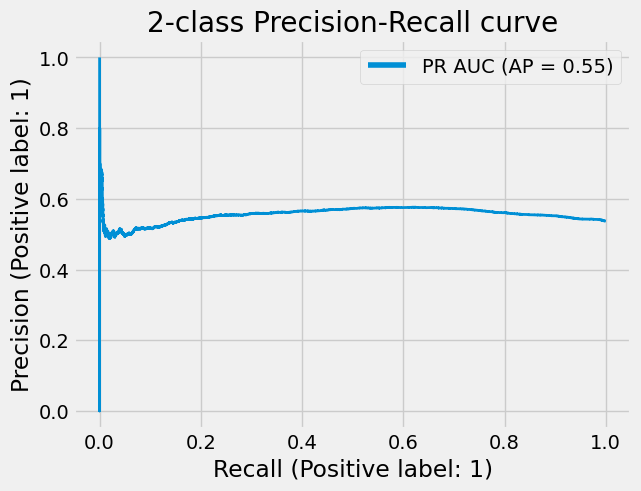

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.55763
    obj_num: 15991
    obj_pct: 0.79
    obj_profit: 1843
ic| bound: 0.411
    score: 0.55776
    obj_num: 15910
    obj_pct: 0.79
    obj_profit: 1838
ic| bound: 0.412
    score: 0.55828
    obj_num: 15820
    obj_pct: 0.78
    obj_profit: 1844
ic| bound: 0.413
    score: 0.5586
    obj_num: 15741
    obj_pct: 0.78
    obj_profit: 1845
ic| bound: 0.414
    score: 0.55905
    obj_num: 15657
    obj_pct: 0.78
    obj_profit: 1849
ic| bound: 0.415
    score: 0.55991
    obj_num: 15583
    obj_pct: 0.77
    obj_profit: 1867
ic| bound: 0.416
    score: 0.56034
    obj_num: 15512
    obj_pct: 0.77
    obj_profit: 1872
ic| bound: 0.417
    score: 0.56091
    obj_num: 15416
    obj_pct: 0.76
    obj_profit: 1878
ic| bound: 0.418
    score: 0.56061
    obj_num: 15351
    obj_pct: 0.76
    obj_profit: 1861
ic| bound: 0.419
    score: 0.56114
    obj_num: 15269
    obj_pct: 0.76
    obj_profit: 1867
ic| bound: 0.42
    score: 0.56123
    obj_num: 15197
    obj_

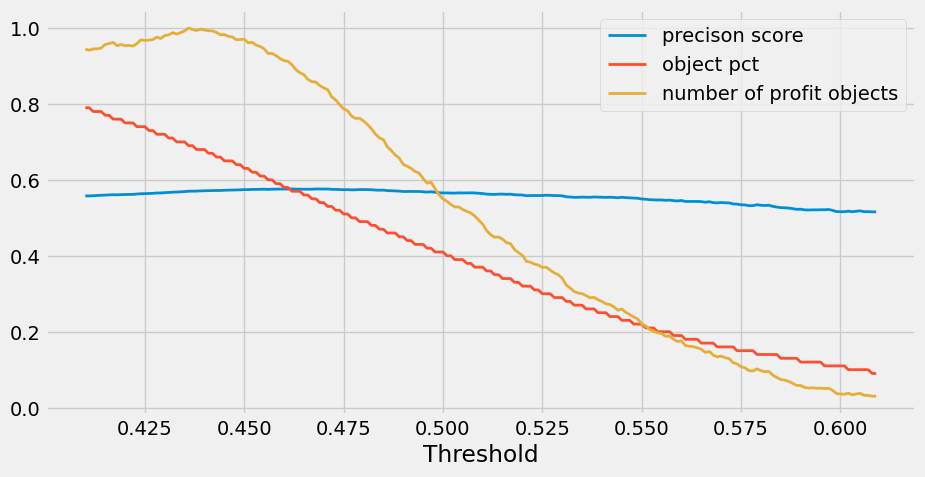

In [ ]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

### Model feature importance

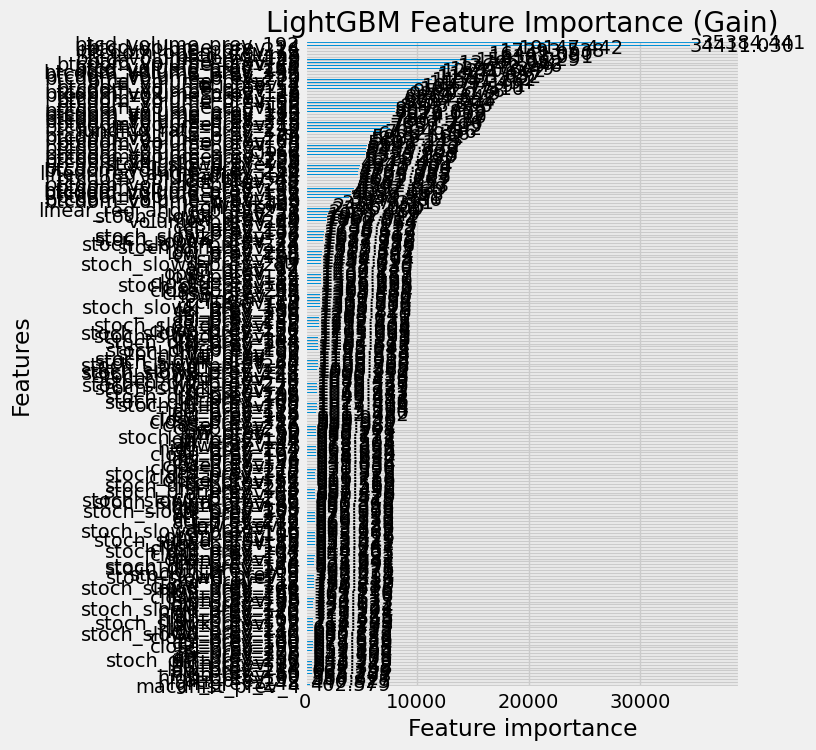

In [ ]:
if not CFG.optimize and train_test == "fold":
    lgb.plot_importance(model, importance_type="gain", figsize=(5, 8), title="LightGBM Feature Importance (Gain)")
    plt.show()

# Error analysis

### Distribution of model pseudo-residuals

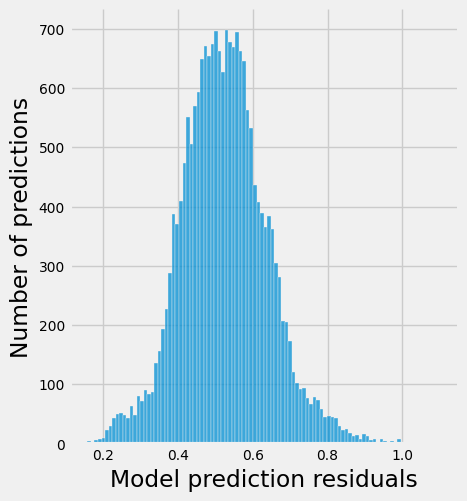

In [ ]:
def logloss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """LogLoss terms"""
    if (y_pred <= 0).any() or (y_pred >= 1).any():
        raise ValueError("y_pred must be between 0 and 1")
    if ((y_true != 0) & (y_true != 1)).any():
        raise ValueError("y_true must be 0 or 1")
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    return y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)


if not CFG.optimize and train_test == "fold":
    residual_df = train_df.loc[val_idxs, ["target"]]
    residual_df["pred"] = oof.ravel()
    y_true = residual_df["target"].values
    y_pred = residual_df["pred"].values
    residuals = -logloss(y_true, y_pred)
    residual_df["residuals"] = residuals
    
    sns.displot(np.log1p(residuals), bins=100)

    plt.xlabel("Model prediction residuals")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Pseudo-residuals vs Predictions plot

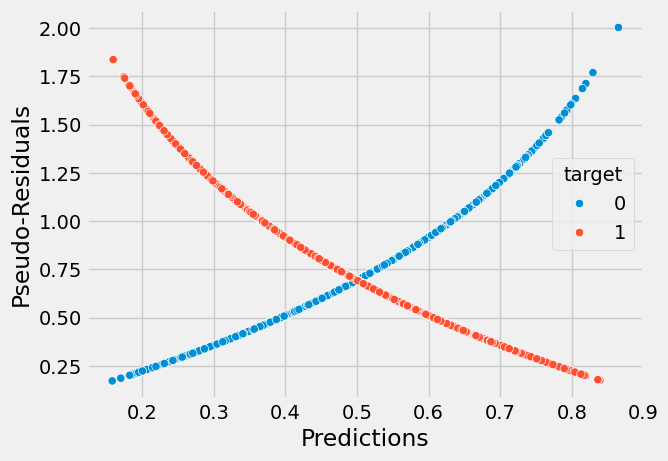

In [ ]:
if not CFG.optimize and train_test == "fold":
    sns.scatterplot(residual_df, x="pred", y="residuals", hue="target")
    plt.xlabel("Predictions")
    plt.ylabel("Pseudo-Residuals");

### Residual stat tests

In [ ]:
from stat_tests import test_normality, test_unbiased, test_homoscedasticity

if not CFG.optimize and train_test == "fold":
    display(test_normality(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is not normal
    display(test_unbiased(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is biased
    display(test_homoscedasticity(y_true, y_pred, bins=30, alpha=0.05)) # p-value < 0.05 -> residuals distribution is heteroscedastic

p-value may not be accurate for N > 5000.


(0.0, True)

(8.10893159261041e-57, True)

(0.0, True)

### Show worst predictions

In [ ]:
if not CFG.optimize and train_test == "fold":
    worst_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10).index
    worst_idxs_df = train_df.loc[worst_idxs, ["time", "ticker", "target", "ttype"]]
    worst_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10)["pred"]
    worst_idxs_df

### Show best predictions

In [ ]:
if not CFG.optimize and train_test == "fold":
    best_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10).index
    best_idxs_df = train_df.loc[best_idxs, ["time", "ticker", "target", "ttype"]]
    best_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10)["pred"]
    best_idxs_df

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- different time for prediction

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [ ]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred", "target", "pattern"]]
    res = cap_max_num_simult_trades(res, CFG.max_num_simult_trades)
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res[["time", "ticker", "ttype", "pred", "target"]].tail(50))

Timestamp('2024-09-20 19:00:00')

Timestamp('2024-12-22 03:00:00')

0    2803
1    2517
Name: target, dtype: int64

0    0.52688
1    0.47312
Name: target, dtype: float64

,time,ticker,ttype,pred,target
5270,2024-12-20 16:00:00,XNOUSDT,buy,0.612017,0
5271,2024-12-20 16:00:00,GALAUSDT,buy,0.562232,0
5272,2024-12-20 16:00:00,BATUSDT,buy,0.558605,0
5273,2024-12-20 16:00:00,BCHUSDT,buy,0.589605,0
5274,2024-12-20 16:00:00,PNUTUSDT,buy,0.592053,0
5275,2024-12-20 16:00:00,1000XUSDT,buy,0.539396,0
5276,2024-12-20 16:00:00,BENDOGUSDT,buy,0.598952,0
5277,2024-12-20 16:00:00,ZECUSDT,buy,0.555354,0
5278,2024-12-20 16:00:00,SUNDOGUSDT,buy,0.550624,0
5279,2024-12-20 16:00:00,ALEOUSDT,buy,0.547102,0


In [ ]:
# Timestamp('2024-10-20 21:00:00')
# Timestamp('2024-12-22 01:00:00')
# 1    1288
# 0    1265
# Name: target, dtype: int641    0.504505
# 0    0.495495
# Name: target, dtype: float64

### Plot rolling mean precision score of the model predictions for the test data

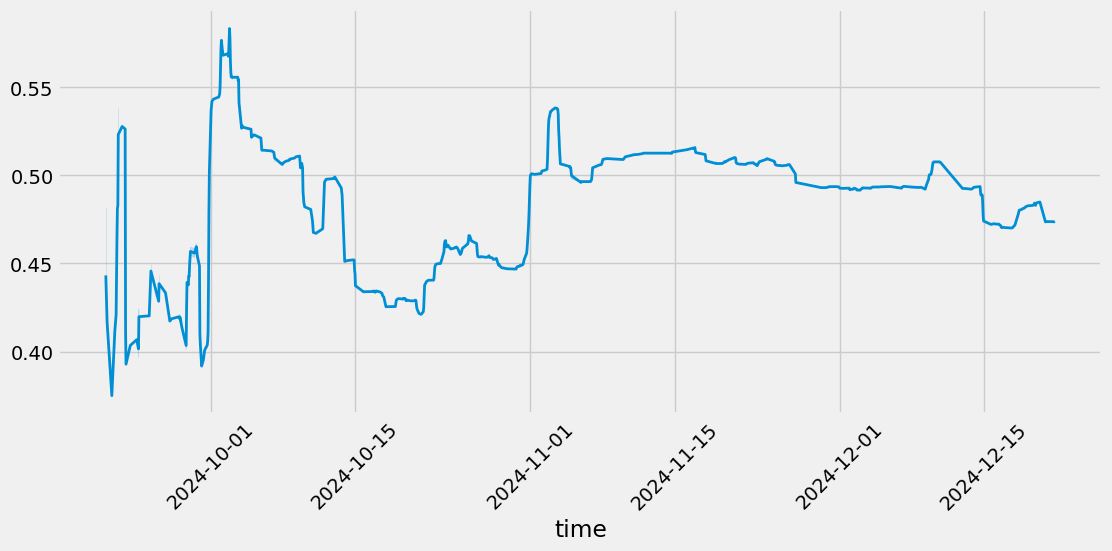

In [ ]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

### Show model uncertainty on test data

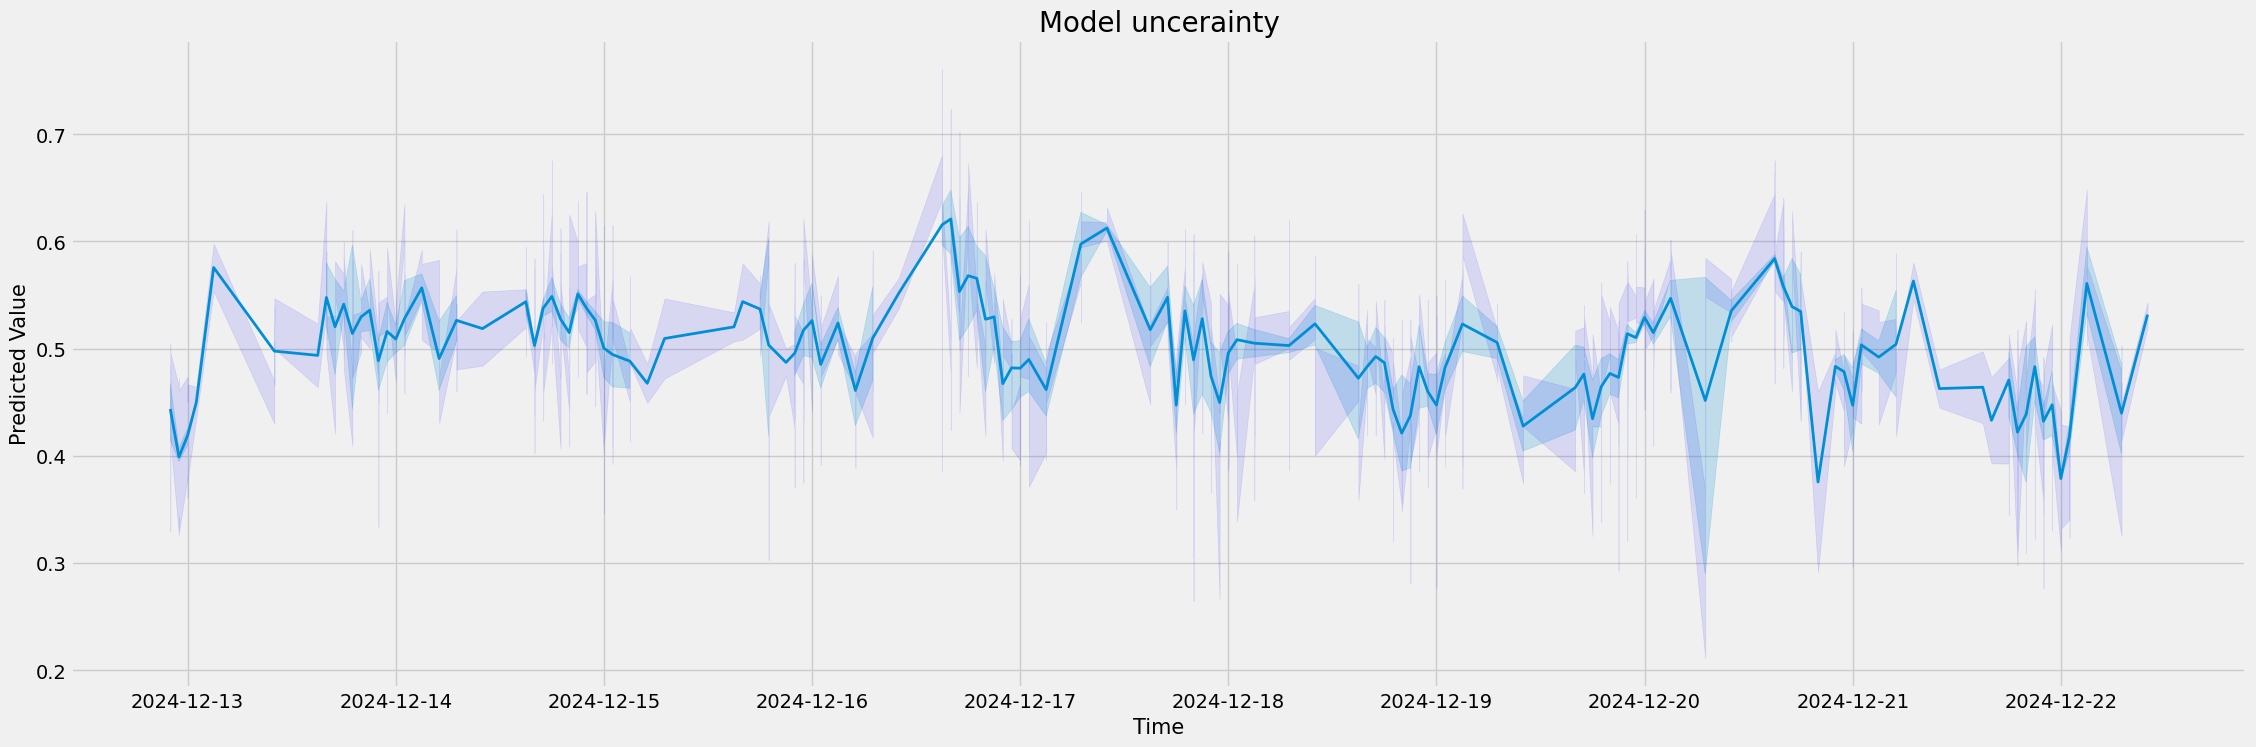

In [ ]:
from boosting_uncertainty import predict_with_uncertainty

mask = train_df["time"] >= train_df["time"].max() - pd.to_timedelta(10, unit="d")
prediction_dict = predict_with_uncertainty(model, train_df.loc[mask, features], k=20)

ticker = train_df.loc[mask, "ticker"]
time = train_df.loc[mask, "time"]

pred = prediction_dict.pred_virt#[mask]
lcb = prediction_dict.lcb#[mask]
ucb = prediction_dict.ucb#[mask]

plt.figure(figsize=(25, 8))
plt.title("Model uncerainty", fontsize=20)
sns.lineplot(x=time, y=pred, linewidth=2)
plt.fill_between(time, lcb, ucb, color='b', alpha=.1)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Predicted Value", fontsize=15);

# Compare indicator / signal values for bot and optimizer

In [ ]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])